<a href="https://colab.research.google.com/github/TanOnRush/DSRP/blob/main/DSRP_NASA_Meteorite_Landings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSRP: NASA Meteorite Landings**

This notebook explores a comprehensive dataset from **The Meteoritical Society**, detailing all known meteorite landings across the globe. The data was originally curated in a Fusion Table by **Javier de la Torre** and is also available as an XLS file.

The dataset includes **34,513 meteorite entries**, with the following key attributes:

- `place`: Location name of the meteorite landing
- `type_of_meteorite`: Classification of the meteorite
- `mass_g`: Mass of the meteorite in grams
- `fell_found`: Whether it was observed falling or later found
- `year`: Year of the landing or discovery
- `database`: Source database identifier
- `coordinate_1` / `coordinates_2`: Original coordinate values
- `cartodb_id`: CartoDB record ID
- `created_at` / `updated_at`: Timestamps for record creation and modification
- `year_date`: Full date reference
- `longitude` / `latitude`: Geographic coordinates
- `geojson`: GeoJSON representation for mapping purposes

[Dataset](https://data.nasa.gov/dataset/meteorite-landings) |
[Project Guide](https://docs.google.com/document/d/1s9s_jMi1Dyn21nLuOzUVnksSAA7MIJD8lD3z7uhz_uc/edit?tab=t.0)

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the dataset
url = "https://data.nasa.gov/docs/legacy/meteorite_landings/Meteorite_Landings.csv"
nasa_df = pd.read_csv(url)
df = nasa_df

In [2]:
# Previewing the datasets
nasa_df

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"
...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037, 17.0185)"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.78333, 8.96667)"
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.25, 17.66667)"
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.78917, 41.5046)"


In [3]:
# Viewing info
nasa_df.info()
nasa_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


,id,mass (g),year,reclat,reclong
count,45716.000000,4.558500e+04,45425.000000,38401.000000,38401.000000
mean,26889.735104,1.327808e+04,1991.828817,-39.122580,61.074319
std,16860.683030,5.749889e+05,25.052766,46.378511,80.647298
min,1.000000,0.000000e+00,860.000000,-87.366670,-165.433330
25%,12688.750000,7.200000e+00,1987.000000,-76.714240,0.000000
50%,24261.500000,3.260000e+01,1998.000000,-71.500000,35.666670
75%,40656.750000,2.026000e+02,2003.000000,0.000000,157.166670
max,57458.000000,6.000000e+07,2101.000000,81.166670,354.473330


In [4]:
# Checking the count of null values
null_counts = df.isnull().sum()
print(null_counts)
null_percent = df.isnull().mean() * 100
print(null_percent)

name              0
id                0
nametype          0
recclass          0
mass (g)        131
fall              0
year            291
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64
name            0.000000
id              0.000000
nametype        0.000000
recclass        0.000000
mass (g)        0.286552
fall            0.000000
year            0.636539
reclat         16.000962
reclong        16.000962
GeoLocation    16.000962
dtype: float64


In [5]:
# Converting reclat and reclong to numeric
df['reclat'] = pd.to_numeric(df['reclat'], errors='coerce')
df['reclong'] = pd.to_numeric(df['reclong'], errors='coerce')

# Dropping the rows with missing and invalid coordinates
df = df.dropna(subset=['reclat', 'reclong'])

# Filtering out the entries where both lat and long are 0.0
filtered_df = nasa_df[
    (nasa_df['reclat'] != 0.0) & (nasa_df['reclong'] != 0.0)
].dropna(subset=['reclat', 'reclong']).copy()

Geographic distribution plot saved as meteorite_geographic_distribution.png


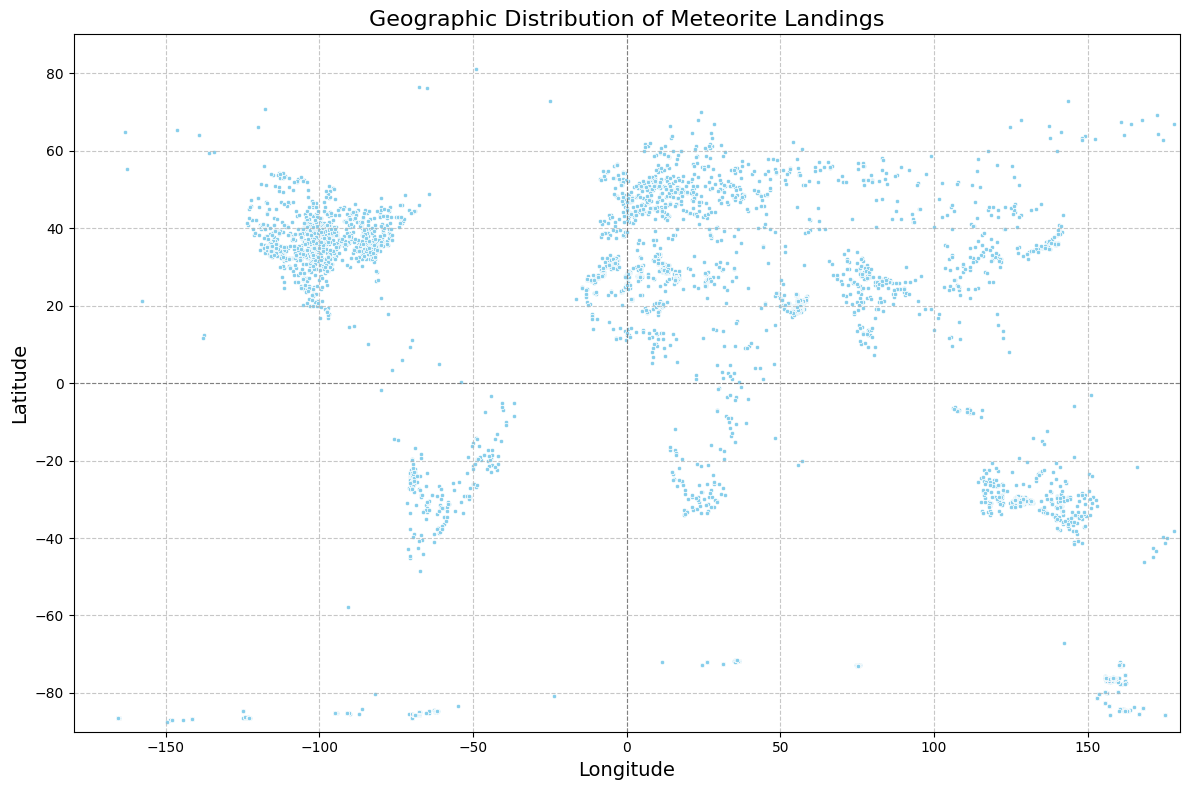

In [6]:
# Visualization
plt.figure(figsize=(12,8))

# Scatter plot
sns.scatterplot(
    x='reclong',
    y='reclat',
    data=filtered_df,
    s=10, #Marker size
    color='skyblue',
    edgecolor='w',
    linewidth=0.5
)

plt.title('Geographic Distribution of Meteorite Landings', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Setting limits for latitude and longitude to represent a global map
plt.xlim(-180, 180)
plt.ylim(-90, 90)

plt.grid(True, linestyle='--', alpha=0.7) # Add a grid
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Equator
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8) # Prime Meridian

plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Save the plot
plt.savefig('meteorite_geographic_distribution.png')
print("Geographic distribution plot saved as meteorite_geographic_distribution.png")

# Display the plot
plt.show()